# Legendre polynomials 

_CYBR 304_ <br>
_Spring 2024_ <br>

A recursion for the Legendre polynomials is $(n+1) P_{n+1}(x) = (2n+1) x P_n(x) - n P_{n-1}(x)$, and $P_0(x) = 1$ and $P_1(x) = x$.  Here is a non-tail recursive function that evaluates the Legendre polynomials that uses this recursion.

In [2]:
"""
    legendre_poly(n::Integer, x::Number)

Compute the nth order Legendre polynomial evaluated at x. The value returned has the same type as the input `x`.
The order `n` must be a nonnegative integer; if not, an  `ArgumentError` is thrown.


For information on Legendre polynomials, refer to DLMF Section 14.1](https://dlmf.nist.gov/14.1). 
"""
function legendre_poly(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be nonnegative; found $n"))
    if n == 0 
        return one(x)
    elseif n == 1
        return x
    else
       return ((2 * n - 1) * x * legendre_poly(n - 1, x) - (n - 1) * legendre_poly(n - 2, x)) / n
    end
end


legendre_poly

In [3]:
? legendre_poly

search: legendre_poly



```
legendre_poly(n::Integer, x::Number)
```

Compute the nth order Legendre polynomial evaluated at x. The value returned has the same type as the input `x`. The order `n` must be a nonnegative integer; if not, an  `ArgumentError` is thrown.

For information on Legendre polynomials, refer to DLMF Section 14.1](https://dlmf.nist.gov/14.1). 


Let's do a simple test.  An explicit representation for the order 5 Legendre polynomial. Let's graph the difference
between the explicit representation and the value given by our code

In [5]:
P5 = x -> @evalpoly(x,0, 15/8, 0, -35/4, 0, 63/8)

#1 (generic function with 1 method)

In [6]:
using Gadfly
my_palette = ["#800080", "#8A2BE2"];

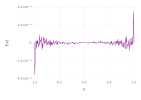

In [7]:
plot([x -> legendre_poly(5, x)-P5(x)],-1, 1, Theme(default_color = my_palette[1], panel_fill = colorant"white"))

And a graph of the relative difference:

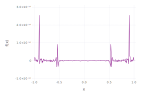

In [9]:
plot([x -> (legendre_poly(5, x)-P5(x))/P5(x)],-1, 1, Theme(default_color = my_palette[1], panel_fill = colorant"white"))

Let's show that our code is super pokey slow for large orders. The effort to compute `legendre_poly(40, 0.23)` should be twice that of `legendre_poly(20, 0.23)`, but the difference is far greater. It's not too hard to show that the running time to compute the nth order Legendre polynomial is about  $O(1.6^n)$, but it should be $O(n)$

using BenchmarkTools

In [12]:
@btime legendre_poly(20, 0.23)

LoadError: LoadError: UndefVarError: `@btime` not defined
in expression starting at In[12]:1

In [13]:
@btime legendre_poly(40, 0.23)

LoadError: LoadError: UndefVarError: `@btime` not defined
in expression starting at In[13]:1

To make this code more efficient, we could either convert the function to be a memoizing function or write it as a purely iterative fashion. (It's possible to write the code as recursive, but make it more efficient, but I think it's  easier to write is as a purely iterative code.)

In [15]:
"""
    legendre_poly(n::Integer, x::Number)

Compute the nth order Legendre polynomial evaluated at the number x. Except for integer inputs, the value returned has 
the same type as the input `x`. The order `n` must be a nonnegative integer; if not, an  `ArgumentError` is thrown.  

For a floating point number 'x', the cost of evaluating legendre_poly(n, x) is O(n).

For information on Legendre polynomials, refer to [DLMF Section 14.1](https://dlmf.nist.gov/14.1).
"""
function legendre_poly(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
  
    if n == 0 
        one(x)
    elseif n == 1
        x
    else
        p0 = one(x)
        p1 = x
        for k in 2:n
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0) / k)
        end
        p1
    end
end


legendre_poly

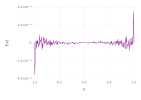

In [16]:
plot([x -> legendre_poly(5, x)-P5(x)],-1, 1, Theme(default_color = my_palette[1], panel_fill = colorant"white"))

The claim is that except for integer inputs, the type of the output is the same as the input `x`. This passes some simple tests:

In [18]:
legendre_poly(5,3)

1683.0

In [19]:
legendre_poly(5,0.45)

0.19172214843749996

In [20]:
legendre_poly(5,BigInt(45)//100)

4908087//25600000

In [21]:
legendre_poly(5, 1//2+im//8)

9563//65536 - 78497//262144*im

In [22]:
legendre_poly(5,BigFloat(0.45))

0.1917221484374999797272842022577415802059330445251014673846118132473028681834638

For inputs that are not Julia numbers, we get a method error

In [24]:
legendre_poly(5,[1,2,3])

LoadError: MethodError: no method matching legendre_poly(::Int64, ::Vector{Int64})

[0mClosest candidates are:
[0m  legendre_poly(::Integer, [91m::Number[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[15]:11[24m[39m


For large orders, the code can overflow, and subtraction in `(p1, ((2*k - 1)*x*p1 - (k - 1)*p0) / k)` gives 'NaN'. An example

In [26]:
xBig = legendre_poly(5000, -BigInt(1018)//1000);

In [27]:
convert(Float64,xBig)

Inf

In [28]:
convert(BigFloat,xBig)

3.507125816771689651646805465256659061290731359063767733573506329102986319756505e+409

In [29]:
legendre_poly(5000, -1.018)

NaN

Possibly the code should monitor for overflow and bailout when that happens; for example

In [31]:
function legendre_poly(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be nonnegative; found $n"))
  
    if n == 0 
        one(x)
    elseif n == 1
        return x
    else
        p0 = one(x)
        p1 = x
        k = 2
        while k <= n && ! isinf(p1)
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0) / k)
            k += 1
        end
        if isinf(p1) throw(OverflowError("Evaluating Legendre($n, $x) overflows")) else p1 end
    end
end

legendre_poly (generic function with 1 method)

In [32]:
legendre_poly(5000, -1.018)

LoadError: OverflowError: Evaluating Legendre(5000, -1.018) overflows

In [33]:
xFloat64 = legendre_poly(1000,63/64)

0.055804783310132236

In [34]:
xBig = legendre_poly(1000, BigInt(63)//64);

In [35]:
convert(Float64,xBig)

0.055804783310132756

In [36]:
(xFloat64 - xBig)/xBig

-9.354788688504714639212738920299980125396300776383578512356126962499035137415198e-15

In [37]:
using LegendrePolynomials

A graph of there difference shows that the outputs are so similar, they must use the same algorithm

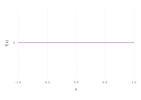

In [39]:
plot([x -> legendre_poly(50, x)-Pl(x,50)],-1, 1, Theme(default_color = my_palette[1], panel_fill = colorant"white"))

But the standard package seems to disallow inputs outside the interval $[-1,1]$

In [41]:
Pl(0.4 + im, 10)

LoadError: DomainError with 0.4 + 1.0im:
Legendre Polynomials are defined for arguments lying in -1 ⩽ x ⩽ 1

In [42]:
Pl(1.23, 10)

LoadError: DomainError with 1.23:
Legendre Polynomials are defined for arguments lying in -1 ⩽ x ⩽ 1

Contrary to the message "arguments lying in -1 ⩽ x ⩽ 1", the code seems OK with the input $0.4 + 0.6 im$.

In [44]:
Pl(0.4 + 0.6*im, 10)

59.166549759999974 - 23.563770700800013im

In [45]:
legendre_poly(10, 0.4+0.6im)

59.166549759999974 - 23.563770700800013im

In [46]:
function legendre_poly(n::Integer, x)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be nonnegative; found $n"))
  
    if n == 0 
        one(x)
    elseif n == 1
        return x
    else
        p0 = one(x)
        p1 = x
        k = 2
        while k <= n
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0) / k)
            k += 1
        end
       p1
    end
end

legendre_poly (generic function with 2 methods)

In [47]:
m = [1/(i+j) for i = 1:5, j = 1:5]

5×5 Matrix{Float64}:
 0.5       0.333333  0.25      0.2       0.166667
 0.333333  0.25      0.2       0.166667  0.142857
 0.25      0.2       0.166667  0.142857  0.125
 0.2       0.166667  0.142857  0.125     0.111111
 0.166667  0.142857  0.125     0.111111  0.1

In [48]:
legendre_poly(5,m)

5×5 Matrix{Float64}:
 0.951214  0.63691   0.479126  0.384154  0.320677
 0.63691   0.477243  0.381644  0.317972  0.272516
 0.479126  0.381644  0.317322  0.271613  0.237437
 0.384154  0.317972  0.271613  0.237167  0.21052
 0.320677  0.272516  0.237437  0.21052   0.18915